In [6]:
%pip install wheel

Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install tensorflow matplotlib tensorflow-datasets ipywidgets

  Using cached tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (3.6 kB)
  Using cached matplotlib-3.8.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached tensorflow_datasets-4.9.4-py3-none-any.whl.metadata (9.2 kB)
  Using cached ipywidgets-8.1.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached tensorflow_macos-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.2 kB)
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.10.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached libclang-16.0.6-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached numpy-1.26.2-cp311-c

In [8]:
%pip install tensorflow-metal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.3 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


## Dataset

In [11]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [24]:
ds = tfds.load('uc_merced', split='train', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2100 [00:00<?, ? examples/s]

Shuffling /Users/ishaandey/tensorflow_datasets/uc_merced/2.0.0.incompleteLYQZAQ/uc_merced-train.tfrecord*...: …

Dataset uc_merced downloaded and prepared to /Users/ishaandey/tensorflow_datasets/uc_merced/2.0.0. Subsequent calls will reuse this data.


In [25]:
ds.as_numpy_iterator().next()

{'filename': b'harbor22.tif',
 'image': array([[[ 16,  18,  15],
         [  2,   5,   3],
         [  2,   7,   4],
         ...,
         [ 58,  54,  65],
         [123, 118, 129],
         [190, 185, 194]],
 
        [[  2,   4,   2],
         [  1,   3,   0],
         [  0,   4,   1],
         ...,
         [ 48,  42,  53],
         [126, 120, 132],
         [198, 192, 202]],
 
        [[  1,   3,   0],
         [  3,   7,   2],
         [  3,   8,   3],
         ...,
         [ 45,  41,  51],
         [119, 115, 126],
         [186, 182, 191]],
 
        ...,
 
        [[122, 126, 113],
         [113, 117, 105],
         [104, 108,  97],
         ...,
         [172, 171, 167],
         [181, 179, 177],
         [195, 194, 194]],
 
        [[180, 184, 169],
         [174, 178, 164],
         [169, 173, 160],
         ...,
         [104,  99,  96],
         [115, 109, 107],
         [131, 126, 126]],
 
        [[195, 199, 184],
         [195, 199, 184],
         [197, 201, 186],
   

In [26]:
import numpy as np

In [27]:
dataiterator = ds.as_numpy_iterator()

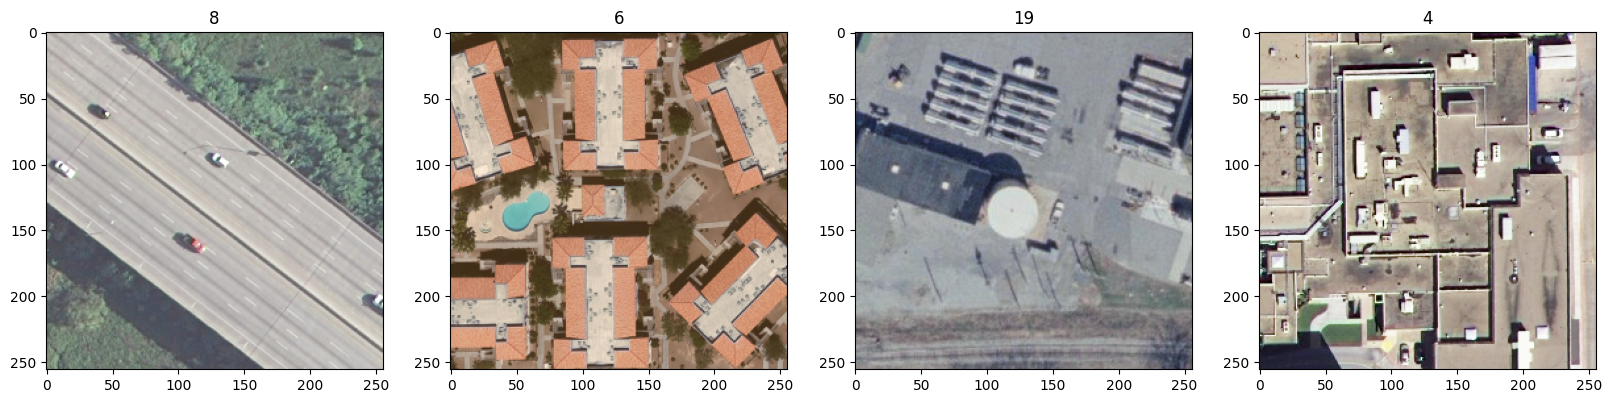

In [227]:
fig, ax = plt.subplots(1, 4, figsize=(20, 20))

for i in range(4):
    sample = dataiterator.next()   
    ax[i].imshow(sample['image'])
    ax[i].set_title(sample['label'])
  

In [319]:
def scale(data):
    image = data['image']

    #resize to 256x256
    image = tf.image.resize(image, (256, 256))

    return image / 255

In [389]:
ds = tfds.load('uc_merced', split='train')

#preprocessing
ds = ds.map(scale)
ds = ds.cache()
ds = ds.shuffle(2100)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [390]:
ds.as_numpy_iterator().next().shape

(128, 256, 256, 3)

## Generator

In [391]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Reshape, LeakyReLU, UpSampling2D

In [392]:
def build_generator():
  model = Sequential()

  model.add(Dense(8*8*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((8, 8, 128)))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #conv block
  model.add(Conv2D(128, kernel_size=3, padding='same'))
  model.add(LeakyReLU(0.2))

  #conv block
  model.add(Conv2D(128, kernel_size=3, padding='same'))
  model.add(LeakyReLU(0.2))


  model.add(Conv2D(3, kernel_size=3, padding='same', activation='sigmoid'))


  return model

In [393]:
generator = build_generator()

In [394]:
generator.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 8192)              1056768   
                                                                 
 leaky_re_lu_175 (LeakyReLU  (None, 8192)              0         
 )                                                               
                                                                 
 reshape_26 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d_72 (UpSampli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_167 (Conv2D)         (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_176 (LeakyReLU  (None, 16, 16, 128)     

In [403]:
img = generator.predict(np.random.randn(4,128,1))


1/1 [==============================] - 0s 144ms/step


In [396]:
img.shape

(4, 256, 256, 3)

1/1 [==============================] - 0s 92ms/step


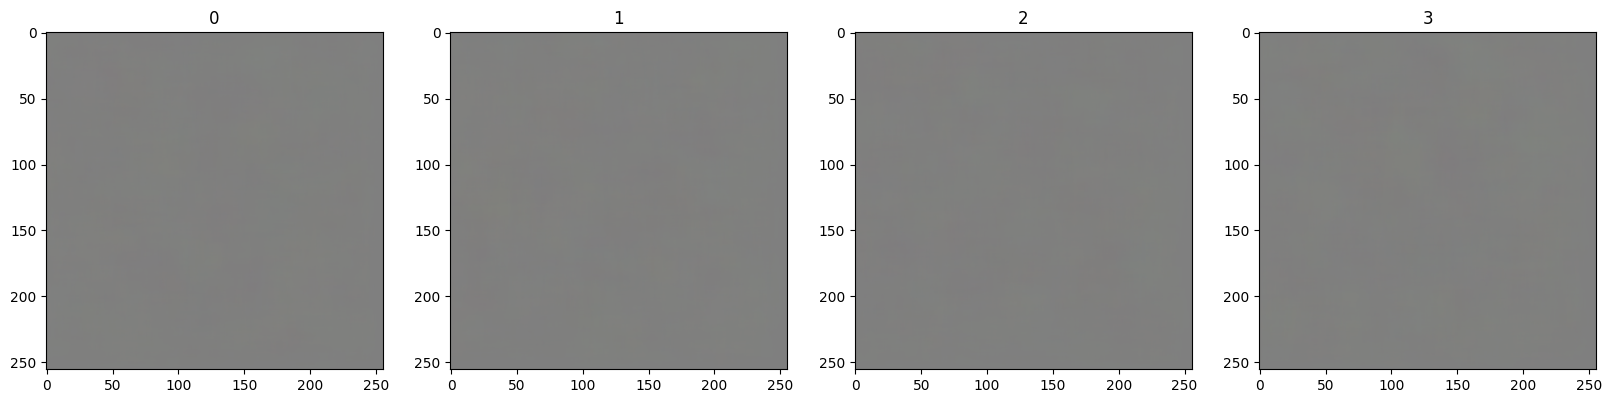

In [397]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(1, 4, figsize=(20, 20))

for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

In [398]:
img.shape

(256, 256, 3)

## Discriminator

In [399]:
def build_discriminator():
  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, input_shape=(256, 256, 3)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Conv2D(64, kernel_size=3))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, kernel_size=3))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Conv2D(256, kernel_size=3))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [400]:
discriminator = build_discriminator()

In [401]:
discriminator.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_175 (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu_183 (LeakyReLU  (None, 254, 254, 32)      0         
 )                                                               
                                                                 
 dropout_46 (Dropout)        (None, 254, 254, 32)      0         
                                                                 
 conv2d_176 (Conv2D)         (None, 252, 252, 64)      18496     
                                                                 
 leaky_re_lu_184 (LeakyReLU  (None, 252, 252, 64)      0         
 )                                                               
                                                                 
 dropout_47 (Dropout)        (None, 252, 252, 64)    

In [404]:
discriminator.predict(img)

1/1 [==============================] - 0s 106ms/step


array([[0.500083 ],
       [0.5000564],
       [0.5001638],
       [0.5001058]], dtype=float32)

## Training Loop

In [405]:
from tensorflow.keras.losses import BinaryCrossentropy  
# m1 mac optimization
from tensorflow.keras.optimizers.legacy import Adam

In [406]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
d_loss = BinaryCrossentropy()
g_loss = BinaryCrossentropy()

In [407]:
from tensorflow.keras.models import Model

In [408]:
class GAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        with tf.GradientTape() as d_tape: 
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        with tf.GradientTape() as g_tape: 
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [409]:
gan = GAN(generator, discriminator)

In [410]:
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [411]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [412]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [413]:
ds.as_numpy_iterator().next().shape

(128, 256, 256, 3)

In [414]:
hist = gan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20


In [368]:
# check tensorflow version
import tensorflow as tf
tf.__version__

'2.15.0'